# Laboratory 8 - Model Evaulation

In [64]:
import numpy as np
import MVGClassifier
import MVGTClassifier
import sklearn.datasets
import matplotlib.pyplot as plt
def load_iris():
    D, L = sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
    return D, L

## Confusion matrix - IRIS dataset

In [65]:
D, L = load_iris()
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0) # 2/3 of the dataset D are used for training, 1/3 for validation
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1]) # take a random array of 150 elements, each element is 0<x<=149 (np.arange(150))
    idxTrain = idx[0:nTrain] # first 100 are indices of training samples 
    idxTest = idx[nTrain:] # remaining 50 are indices of validation samples
    DTR = D[:, idxTrain] # D for training
    DTE = D[:, idxTest] # D for validation
    LTR = L[idxTrain] # L for training
    LTE = L[idxTest] # L for validation
    return (DTR, LTR), (DTE, LTE)
(DTR, LTR), (DTE, LTE) = split_db_2to1(D, L)

## MVG classifier

In [66]:
mvg_classifier = MVGClassifier.MVG(DTR, LTR)
mvg_classifier.train()
predicted_labels = mvg_classifier.test(DTE, LTE)
conf_matrix_MVG = mvg_classifier.confusion_matrix(predicted_labels, LTE)
conf_matrix_MVG

array([[19.,  0.,  0.],
       [ 0., 15.,  0.],
       [ 0.,  2., 14.]])

## Tied Covariance classifier

In [67]:
tied_classifier = MVGTClassifier.MVGT(DTR, LTR)
tied_classifier.train()
predicted_labels = tied_classifier.test(DTE, LTE)
conf_matrix_MVGT = tied_classifier.confusion_matrix(predicted_labels, LTE)
conf_matrix_MVGT

array([[19.,  0.,  0.],
       [ 0., 16.,  0.],
       [ 0.,  1., 14.]])

## Divina Commedia classfier

### Confusion matrix

In [68]:
commedia_labels = np.load('Data/commedia_labels.npy')
class_conditional_ll = np.load('Data/commedia_ll.npy')

In [69]:
predicted_labels = np.argmax(class_conditional_ll,axis=0)
i = 0
conf_matrix = np.zeros(shape=(3,3))
for predicted_label in predicted_labels:
    actual_label = commedia_labels[i] # class 0,1,2
    if predicted_label == actual_label: # correct label
        conf_matrix[predicted_label][predicted_label] += 1
    else:
        conf_matrix[predicted_label][actual_label] += 1
    i+=1
conf_matrix

array([[210., 113.,  61.],
       [137., 191., 111.],
       [ 53.,  98., 230.]])

### Optimal Bayes Decision - binary task

In [70]:
infpar_labels = np.load('Data/commedia_labels_infpar.npy')
infpar_ll = np.load('Data/commedia_llr_infpar.npy')

In [71]:
def build_confusion_matrix(predicted_labels, actual_labels):
    conf_matrix = np.zeros(shape=(2,2))
    i = 0
    for pl in predicted_labels:
        if pl == actual_labels[i]:
            conf_matrix[pl][pl] += 1
        else:
            conf_matrix[pl][actual_labels[i]] += 1
        i += 1
    return conf_matrix

In [75]:
def compute_optimalBayes_confusionMatrix(scores, actual_labels, pi1, Cfn, Cfp):
    conf_matrix = np.zeros(shape=(2,2))
    t = -np.log((pi1*Cfn)/((1-pi1)*Cfp))
    predicted_labels = np.array(scores > t, dtype='int32')
    return build_confusion_matrix(predicted_labels, actual_labels)

In [76]:
pi1 = 0.5
Cfn=1
Cfp=1
compute_optimalBayes_confusionMatrix(infpar_ll, infpar_labels, pi1,Cfn,Cfp)

array([[293.,  96.],
       [109., 304.]])

In [77]:
pi1 = 0.8
Cfn=1
Cfp=1
compute_optimalBayes_confusionMatrix(infpar_ll, infpar_labels, pi1,Cfn,Cfp)

array([[271.,  80.],
       [131., 320.]])

In [78]:
pi1 = 0.5
Cfn=10
Cfp=1
compute_optimalBayes_confusionMatrix(infpar_ll, infpar_labels, pi1,Cfn,Cfp)

array([[257.,  75.],
       [145., 325.]])

In [79]:
pi1 = 0.8
Cfn=1
Cfp=10
compute_optimalBayes_confusionMatrix(infpar_ll, infpar_labels, pi1,Cfn,Cfp)

array([[302., 113.],
       [100., 287.]])

## Binary tas: evaulation

In [80]:
def compute_DCF(scores, actual_labels, pi1, Cfn, Cfp):
    M = compute_optimalBayes_confusionMatrix(scores, actual_labels, pi1,Cfn,Cfp)
    fnr = M[0,1] / (M[0,1] + M[1,1])
    fpr = M[1,0] / (M[0,0] + M[1,0])
    return pi1 * Cfn * fnr + (1-pi1)*Cfp*fpr

In [81]:
pi1 = 0.5
Cfn=1
Cfp=1
compute_DCF(infpar_ll, infpar_labels, pi1, Cfn, Cfp)

0.25557213930348255

In [82]:
pi1 = 0.5
Cfn=10
Cfp=1
compute_DCF(infpar_ll, infpar_labels, pi1, Cfn, Cfp)

1.1178482587064678

In [83]:
def compute_normalized_DCF(scores, actual_labels, pi1, Cfn, Cfp):
    Bdummy = np.minimum(pi1*Cfn, (1-pi1)*Cfp)
    return compute_DCF(scores, actual_labels, pi1, Cfn, Cfp) / Bdummy

In [84]:
pi1 = 0.5
Cfn=1
Cfp=1
compute_normalized_DCF(infpar_ll, infpar_labels, pi1, Cfn, Cfp)

0.5111442786069651

In [49]:
pi1 = 0.5
Cfn=10
Cfp=1
compute_normalized_DCF(infpar_ll, infpar_labels, pi1, Cfn, Cfp)

2.2356965174129355

## Minimum detection cost

In [92]:
def compute_min_DCF(scores, actual_labels, pi1, Cfn, Cfp):
    scores_sort = np.sort(scores)
    normDCFs = []
    for i in scores_sort:
        predicted_labels = np.where(scores > i+0.000001, 1, 0)
        M = build_confusion_matrix(predicted_labels, actual_labels)
        fnr = M[0,1] / (M[0,1] + M[1,1])
        fpr = M[1,0] / (M[0,0] + M[1,0])
        dcf = pi1 * Cfn * fnr + (1-pi1)*Cfp*fpr
        Bdummy = np.minimum(pi1*Cfn, (1-pi1)*Cfp)
        dcf_norm = dcf / Bdummy
        normDCFs.append(dcf_norm)
    return min(normDCFs)

In [93]:
pi1 = 0.5
Cfn=1
Cfp=1
compute_min_DCF(infpar_ll, infpar_labels, pi1, Cfn, Cfp)

0.5061442786069652

In [95]:
pi1 = 0.8
Cfn=1
Cfp=10
compute_min_DCF(infpar_ll, infpar_labels, pi1, Cfn, Cfp)

0.70931592039801

## Bayes Error Plots

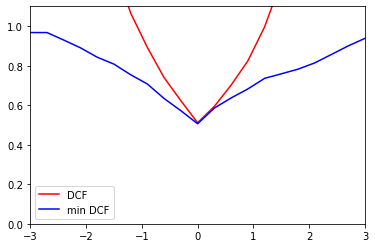

In [96]:
effPriorLogOdds = np.linspace(-3, 3, 21)
effPrior = 1 / (1+np.exp(-effPriorLogOdds))
mindcf = []
dcf = []
for prior in effPrior:
    mindcf.append(compute_min_DCF(infpar_ll, infpar_labels, prior, 1, 1))
    dcf.append(compute_normalized_DCF(infpar_ll, infpar_labels, prior, 1, 1))
plt.plot(effPriorLogOdds, dcf, label='DCF', color='r')
plt.plot(effPriorLogOdds, mindcf, label='min DCF', color='b')
plt.ylim([0, 1.1])
plt.xlim([-3, 3])
plt.legend(['DCF','min DCF'])
plt.show()

### ROC curves

In [97]:
def plotROC(llrs, actual_labels):
    TPR = []
    FPR = []
    llrs_sort = np.sort(llrs)
    for i in llrs_sort:
        predicted_labels = np.where(llrs > i+0.000001, 1, 0)
        conf_matrix = build_confusion_matrix(predicted_labels, actual_labels)
        TPR.append(conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1]))
        FPR.append(conf_matrix[1, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0]))
    plt.plot(np.array(FPR), np.array(TPR))

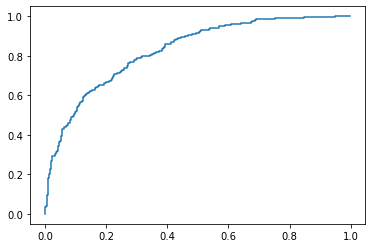

In [98]:
plotROC(infpar_ll, infpar_labels)

## Comparing recognizers

In [99]:
infpar_ll_eps1 = np.load('Data/commedia_llr_infpar_eps1.npy')

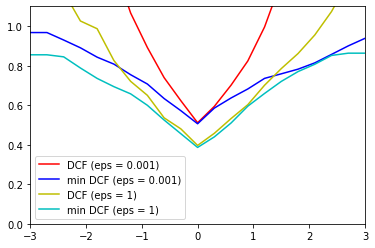

In [101]:
## eps = 0.001
effPriorLogOdds = np.linspace(-3, 3, 21)
effPrior = 1 / (1+np.exp(-effPriorLogOdds))
mindcf = []
dcf = []
for prior in effPrior:
    mindcf.append(compute_min_DCF(infpar_ll, infpar_labels, prior, 1, 1))
    dcf.append(compute_normalized_DCF(infpar_ll, infpar_labels, prior, 1, 1))
## eps = 1
mindcf_eps1 = []
dcf_eps1 = []
for prior in effPrior:
    mindcf_eps1.append(compute_min_DCF(infpar_ll_eps1, infpar_labels, prior, 1, 1))
    dcf_eps1.append(compute_normalized_DCF(infpar_ll_eps1, infpar_labels, prior, 1, 1))
plt.plot(effPriorLogOdds, dcf, label='DCF', color='r')
plt.plot(effPriorLogOdds, mindcf, label='min DCF', color='b')
plt.plot(effPriorLogOdds, dcf_eps1, label='DCF', color='y')
plt.plot(effPriorLogOdds, mindcf_eps1, label='min DCF', color='c')
plt.ylim([0, 1.1])
plt.xlim([-3, 3])
plt.legend(['DCF (eps = 0.001)','min DCF (eps = 0.001)','DCF (eps = 1)','min DCF (eps = 1)'])
plt.show()

In [102]:
def compute_DCF(scores, actual_labels, pi1, Cfn, Cfp):
    M = compute_optimalBayes_confusionMatrix(scores, actual_labels, pi1,Cfn,Cfp)
    fnr = M[0,1] / (M[0,1] + M[1,1])
    fpr = M[1,0] / (M[0,0] + M[1,0])
    return pi1 * Cfn * fnr + (1-pi1)*Cfp*fpr

In [103]:
def compute_optimalBayes_confusionMatrix(scores, actual_labels, pi1, Cfn, Cfp):
    conf_matrix = np.zeros(shape=(2,2))
    t = -np.log((pi1*Cfn)/((1-pi1)*Cfp))
    predicted_labels = np.array(scores > t, dtype='int32')
    return build_confusion_matrix(predicted_labels, actual_labels)

In [104]:
def compute_normalized_DCF(scores, actual_labels, pi1, Cfn, Cfp):
    Bdummy = np.minimum(pi1*Cfn, (1-pi1)*Cfp)
    return compute_DCF(scores, actual_labels, pi1, Cfn, Cfp) / Bdummy

In [105]:
def compute_min_DCF(scores, actual_labels, pi1, Cfn, Cfp):
    scores_sort = np.sort(scores)
    normDCFs = []
    for i in scores_sort:
        predicted_labels = np.where(scores > i+0.000001, 1, 0)
        M = build_confusion_matrix(predicted_labels, actual_labels)
        fnr = M[0,1] / (M[0,1] + M[1,1])
        fpr = M[1,0] / (M[0,0] + M[1,0])
        dcf = pi1 * Cfn * fnr + (1-pi1)*Cfp*fpr
        Bdummy = np.minimum(pi1*Cfn, (1-pi1)*Cfp)
        dcf_norm = dcf / Bdummy
        normDCFs.append(dcf_norm)
    return min(normDCFs)